Global validation of `tasmax`

`da_hist` and `da_ssp370` are data inputs from the cleaned CMIP6 data. 

The data we are comparing:
`da_cmip6` is the regridded data input. `da_bc` is the bias-corrected CMIP6 data. `da_era5` is the ERA-5 reanalysis data. 

In [40]:
%matplotlib inline
import xarray as xr
import numpy as np 
import os 
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import intake
import zarr
import gcsfs

import dask.array as dda

In [41]:
fs = gcsfs.GCSFileSystem(token='/opt/gcsfuse_tokens/impactlab-data.json')

In [ ]:
store_filename = 'gs://impactlab-data/climate/downscaling/clean-cmip6-validation-20210722/ACCESS-ESM1-5/historical/r1i1p1f1/tasmax.zarr' 
store = fs.get_mapper(store_filename, check=False)
ds_hist = xr.open_zarr(store, consolidated=True)

In [ ]:
da_hist = ds_hist['tasmax']

In [ ]:
store_filename = 'gs://impactlab-data/climate/downscaling/clean-cmip6-validation-20210722/ACCESS-ESM1-5/ssp370/r1i1p1f1/tasmax.zarr' 
store = fs.get_mapper(store_filename, check=False)
ds_ssp370 = xr.open_zarr(store, consolidated=True)

In [ ]:
da_ssp370 = ds_ssp370['tasmax']

Zarr stores that are used below.

In [42]:
store_filename = 'gs://impactlab-data-scratch/regrid-test-tfh2s/ACCESS-ESM1-5/tasmax/biascorrected-rechunked.zarr'
store = fs.get_mapper(store_filename, check=False)
ds_bc = xr.open_zarr(store, consolidated=True)

In [43]:
da_bc = ds_bc['tasmax']
da_bc

<xarray.DataArray 'tasmax' (lat: 180, lon: 360, time: 43800)>
dask.array<xarray-tasmax, shape=(180, 360, 43800), dtype=float64, chunksize=(180, 360, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1980-01-01 12:00:00 ... 2099-12-31 12:00:00
Attributes:
    bias_adjustment:  QuantileDeltaMapping(nquantiles=array([0.005, 0.015, 0....
    xclim_history:    [2021-07-31 02:09:50] : Bias-adjusted with QuantileDelt...

In [44]:
da_bc = da_bc.transpose("time", "lat", "lon")

In [45]:
store_filename = 'gs://impactlab-data/climate/downscaling/biascorrected-validation-20210728/ERA-5/tasmax/reference-regrid.zarr'
store = fs.get_mapper(store_filename, check=False)
ds_era5 = xr.open_zarr(store, consolidated=True)

In [46]:
da_era5 = ds_era5['tasmax']

In [47]:
da_era5_v2 = da_era5.sel(time=slice('1995','2014'))
da_era5_v2

<xarray.DataArray 'tasmax' (time: 7300, lat: 180, lon: 360)>
dask.array<getitem, shape=(7300, 180, 360), dtype=float32, chunksize=(365, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(7300,), meta=np.ndarray>
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-31 00:00:00

In [48]:
store_filename = 'gs://impactlab-data-scratch/regrid-test-tfh2s/ACCESS-ESM1-5/tasmax/gcm-future-regrid.zarr'
store = fs.get_mapper(store_filename, check=False)
ds_cmip6 = xr.open_zarr(store, consolidated=True)

In [49]:
da_cmip6 = ds_cmip6['tasmax']
da_cmip6

<xarray.DataArray 'tasmax' (time: 55115, lat: 180, lon: 360)>
dask.array<xarray-tasmax, shape=(55115, 180, 360), dtype=float32, chunksize=(365, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-31 12:00:00

Defining time periods of interest

In [50]:
start_20yr_periods = ['2020', '2040', '2060', '2080']
end_20yr_periods = ['2040', '2060', '2080', '2100']

In [52]:
def compare_da_to_threshold_per_year(da, method, climo, threshold):
    if method == 'above':
        days_per_threshold = da.where(da > threshold)
    elif method == 'below': 
        days_per_threshold = da.where(da < threshold)
     
    if climo == 'no':
        # count instances of occurrance, average per year for average number of days above threshold
        days_threshold_per_yr = days_per_threshold.groupby(days_per_threshold.time.dt.year).count().mean(dim='year').persist()
        return days_threshold_per_yr
    else:
        days_threshold_per_yr = days_per_threshold.count(dim='dayofyear').persist()
        return days_threshold_per_yr
    
def plot_average_days_above_threshold(da, threshold_value, start_yr, end_yr, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.hot_r 

    da.plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "# of days"},
        vmin=0,
        vmax=300,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title("Average number of days above {}F per year from {}-{}".format(threshold_value, start_yr, end_yr))
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    
def plot_twosubplots(da1, da2, title1, title2, fname):
    fig = plt.figure(figsize=(10, 8))
    cmap = cm.hot_r 
    
    ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
    ax1.plot(da1, cmap=cmap, 
             transform=ccrs.PlateCarree(), cbar_kwargs={"label": "# of days"},
            vmin=0, vmax=300)
    
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linestyle=":")
    ax1.set_title(title1)
    
    ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
    ax2.plot(da2, ax2=ax2, cmap=cmap, 
             transform=ccrs.PlateCarree(), cbar_kwargs={"label": "# of days"},
            vmin=0, vmax=300)
    
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linestyle=":")
    ax2.set_title(title2)
    
    plt.show()
    
    
def plot_difference_days(da1, da2, title, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.RdBu_r

    (da1-da2).plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "# of days"},
        vmin=-100,
        vmax=100,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title)
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')

In [83]:
def plot_globe(da, metric, start_yr, end_yr, data_type, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.cividis 
    
    if metric == 'mean':
        da.sel(time=slice(start_yr,end_yr)).mean(dim='time').plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.8, 'pad': 0.02,"label": "tasmax (K)"},
            vmin=240,
            vmax=310,
        )
    elif metric == 'max':
        da.sel(time=slice(start_yr,end_yr)).max(dim='time').plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.8, 'pad': 0.02,"label": "tasmax (K)"},
            vmin=240,
            vmax=310,
        )
    elif metric == 'min':
        da.sel(time=slice(start_yr,end_yr)).min(dim='time').plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.8, 'pad': 0.02,"label": "tasmax (K)"},
            vmin=240,
            vmax=310,
        )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title("{} tasmax from {}-{} of {} data".format(metric, start_yr, end_yr, data_type))
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    
def plot_difference_temp(da1, da2, title, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.RdBu_r

    (da1-da2).plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "tasmax (K)"},
        vmin=-5,
        vmax=5,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title)
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')

In [54]:
# count instances of occurrance, average per year for average number of days above threshold
high_heat_threshold = 308 #95 F

Mean tasmax of bias-corrected, CMIP6 (2080-2100) and ERA-5 (1995-2014)

In [ ]:
plot_globe(da_bc, 'mean', start_20yr_periods[3], end_20yr_periods[3], 'bias-corrected')

In [ ]:
plot_globe(da_cmip6, 'mean', start_20yr_periods[3], end_20yr_periods[3], 'CMIP6')

In [ ]:
plot_globe(da_era5, 'mean', '1995', '2014', 'ERA-5')

In [ ]:
plot_difference_temp(da_bc.mean(dim='time'), da_era5_v2.mean(dim='time'),
                     'Mean tasmax difference between bias-corrected and ERA-5', 'tasmax_mean_diff_BC_era5')

In [ ]:
plot_difference_temp(da_cmip6.mean(dim='time'), da_era5_v2.mean(dim='time'), 
                     'Mean tasmax difference between CMIP6 and ERA-5', 'tasmax_mean_diff_cmip6_era5')

In [ ]:
plot_difference_temp(da_bc.mean(dim='time'), da_cmip6.mean(dim='time'), 
                     'Mean tasmax difference between bias-corrected and CMIP6', 'tasmax_mean_diff_BC_cmpi6')

Average annual count of days above 95F (308K)

In [55]:
days_above_threshold_bc = compare_da_to_threshold_per_year(da_bc.sel(time=slice(start_20yr_periods[3],end_20yr_periods[3])),
                                                           'above', 'no', high_heat_threshold)

In [56]:
days_above_threshold_cmip6 = compare_da_to_threshold_per_year(da_cmip6.sel(time=slice(start_20yr_periods[3],end_20yr_periods[3])),
                                                           'above', 'no', high_heat_threshold)

In [57]:
days_above_threshold_era5 = compare_da_to_threshold_per_year(da_era5_v2,
                                                           'above', 'no', high_heat_threshold)

Plot global maps of average days above 95F

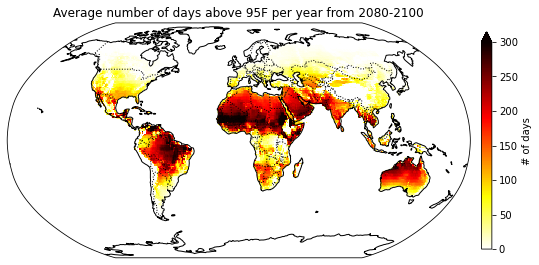

In [58]:
plot_average_days_above_threshold(days_above_threshold_bc, 95, start_20yr_periods[3], end_20yr_periods[3], 'daysabove95_bc_2080-2100')

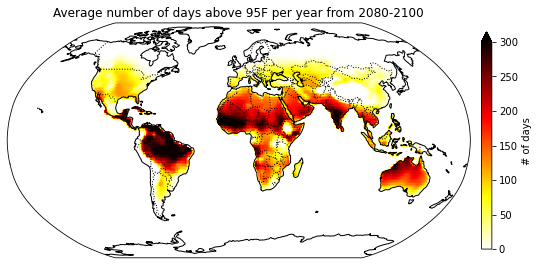

In [59]:
plot_average_days_above_threshold(days_above_threshold_cmip6, 95, start_20yr_periods[3], end_20yr_periods[3], 'daysabove95_cmip6_2080-2100')

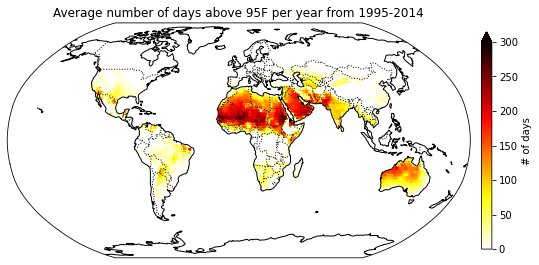

In [60]:
plot_average_days_above_threshold(days_above_threshold_era5, 95, '1995', '2014', 'daysabove95_era5_1995-2014')

Plot difference between number of days above 95F

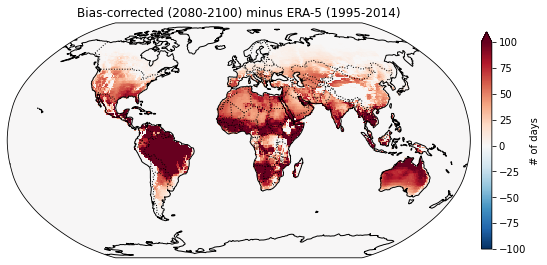

In [62]:
plot_difference_days(days_above_threshold_bc, days_above_threshold_era5, 
                     'Bias-corrected (2080-2100) minus ERA-5 (1995-2014)', 'diff_daysabove95_bc_era5')

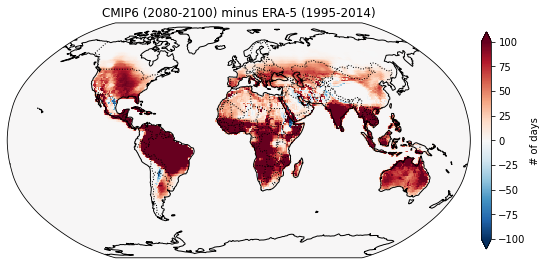

In [63]:
plot_difference_days(days_above_threshold_cmip6, days_above_threshold_era5,
                     'CMIP6 (2080-2100) minus ERA-5 (1995-2014)', 'diff_daysabove95_cmip6_era5')

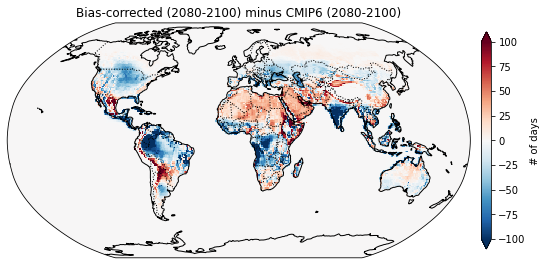

In [61]:
plot_difference_days(days_above_threshold_bc, days_above_threshold_cmip6, 
                     'Bias-corrected (2080-2100) minus CMIP6 (2080-2100)', 'diff_daysabove95_bc_cmip6')

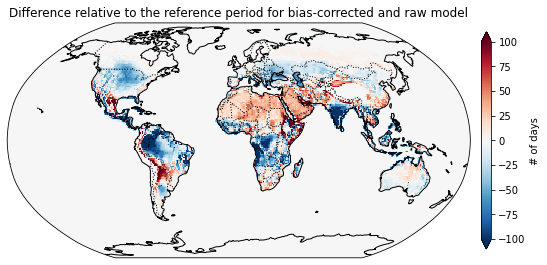

In [68]:
plot_difference_days(diff_bc_era5, diff_cmip6_era5,
                     'Difference relative to the reference period for bias-corrected and raw model', 'diff_daysabove95_relative_comparison')

The two plots above are the same.

Two panel subplot version of above plot.

In [24]:
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(ds_bc['lon'], ds_bc['lat'])

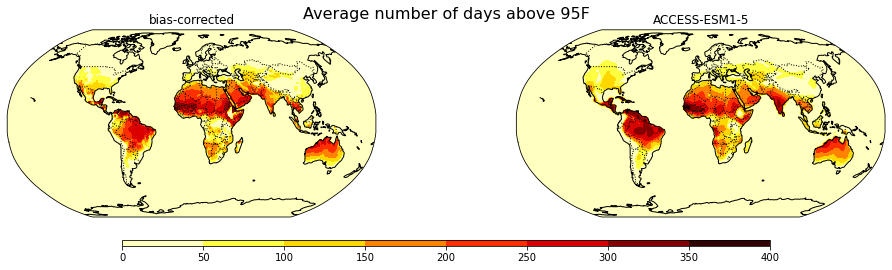

In [82]:
# Create the figure and plot background on different axes
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15, 4),
                          subplot_kw={'projection':ccrs.Robinson()})
cmap = cm.hot_r

axlist = axarr.flatten()

# plot 1
cf1 = axlist[0].contourf(lon_2d, lat_2d, days_above_threshold_bc, cmap=cmap, transform=ccrs.PlateCarree())

#axlist[0].clabel(c1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
axlist[0].set_title('bias-corrected')
axlist[0].coastlines()
axlist[0].add_feature(cfeature.BORDERS, linestyle=":")
#cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='vertical', shrink=0.8, pad=0.02)
#cb1.set_label('knots', size='x-large')

# plot 2
cf2 = axlist[1].contourf(lon_2d, lat_2d, days_above_threshold_cmip6, cmap=cmap, transform=ccrs.PlateCarree())

#axlist[1].clabel(c2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
axlist[1].set_title('ACCESS-ESM1-5')
axlist[1].coastlines()
axlist[1].add_feature(cfeature.BORDERS, linestyle=":")
#cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='vertical', shrink=0.8, pad=0.02)
#cb2.set_label('# of days')

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cf1, cax=cbar_ax,orientation='horizontal')

# Set figure title
fig.suptitle('Average number of days above 95F', fontsize=16)

# Display the plot
plt.show()